<a href="https://colab.research.google.com/github/BDouchet/BMDATA/blob/main/NLP_MLP_Movie_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

The dataset is composed of 2000 movie reviews classified in two categories : posititive and negative review equally reparted. The aim si to create a basic Fully connected Neural Network to predict the sentiment of the review.

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1hUviU_B5cug4mVCLAHe0cWkU55R8vtUu'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('reviews.zip')

with ZipFile('reviews.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


An example of a negative review

In [ ]:
def load_a_review(path,Print=False):
    f = open(path, "r").read()
    if Print:
        print(f)
    return f

file=load_a_review('/content/txt_sentoken/neg/cv000_29416.txt',True)

plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have no id

I read all the reviews in the data folder

In [ ]:
import os
def process_doc(directory):
    doc=[]
    for file in os.listdir(directory):
        doc.append(load_a_review(directory+file))
    return doc

neg=np.array(process_doc('/content/txt_sentoken/neg/'))
pos=np.array(process_doc('/content/txt_sentoken/pos/'))

print(np.array(neg).shape,np.array(pos).shape)

(1000,) (1000,)


I separate the dataset into two datasets : Train and Test made of 1800 and 200 reviews respectively. The number of positive and negative reviews in the datasets is equal. I shuffle the datasets.

In [ ]:
from sklearn.utils import shuffle

x_train=np.concatenate([neg[:900],pos[:900]])
x_test=np.concatenate([neg[900:],pos[900:]])
y_train=np.array([0 for _ in range(900)]+[1 for _ in range(900)])
y_test=np.array([0 for _ in range(100)]+[1 for _ in range(100)])

x_train,y_train=shuffle(x_train,y_train)
x_test,y_test=shuffle(x_test,y_test)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1800,) (1800,) (200,) (200,)


# Text Processing

In this part, I filter the relevant words of the reviews :

*   Take off non relevant words (stopwords) like : to, from, and, if...
*   Keep words with a length >=2
*   Take off words seen only once in the reviews

This filtered words create our dictionnary. The dictionnary is only calculated with the train reviews because test reviews have to be "new" for the network.



In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'yourself', 'to', 'shan', "doesn't", "shouldn't", 'from', 'hasn', 'himself', 'haven', 'hadn', 'weren', 'and', 'if', 'about', "mightn't", "mustn't", 'further', 'too', 'this', 'where', 'over', 'below', 'same', 'are', 'been', 'will', 'any', 'his', 'but', 'of', 'than', 'before', 'by', 'll', "you'd", 'with', 'your', 've', 'between', 'mightn', 'yours', 'so', 'you', 'some', 'was', "you're", "you'll", 'very', 'them', 'nor', "aren't", 'out', 'me', 'which', 'whom', 'when', 'not', 'ours', 'have', 'few', 'wasn', 'a', "that'll", 'being', 'most', 'at', 'that', 'up', 'who', 'only', 'why', 'herself', 'until', 'does', 'as', 'hers', 'just', 'no', 'other', 'more', 'yourselves', "weren't", 'each', 'its', 'didn', 'these', "hasn't", 't', 'during', "won't", 'off', 'needn', 'both', 'how', 'because', 'he', 'be', 'did', 'now', 'in', 'm', "she's", 'ma', 'against', 'him', "you've", 'mustn', 'an'

In [ ]:
import string
import re

re_punc=re.compile('[%s]' % re.escape(string.punctuation))

def clean_review(review):
    tokens=review.split()
    tokens=[re_punc.sub('',w) for w in tokens]
    tokens=[word for word in tokens if word.isalpha()]
    tokens=[word for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if len(word)>1]
    return tokens

print(clean_review('Hello World ! I am a droïd.'))

['Hello', 'World', 'droïd']


I create a vocab to count the number of filtered words in all the reviews.

In [ ]:
def add_words_to_vocab(review,vocab):
    tokens=clean_review(review)
    vocab.update(tokens)

from collections import Counter
vocab_test=Counter()
add_words_to_vocab('hello world ! I am a droïd and I come from droïd world !',vocab_test)
vocab_test.items()

dict_items([('hello', 1), ('world', 2), ('droïd', 2), ('come', 1)])

Creation of the vocab, without surprises the most frequent words are : film, movie, one, like...

In [ ]:
import itertools
vocab=Counter()
for review in x_train:
    add_words_to_vocab(review,vocab)
print(len(vocab.items()))
print(vocab.most_common(10))

44442
[('film', 8062), ('one', 5001), ('movie', 4961), ('like', 3178), ('even', 2299), ('good', 2068), ('time', 2068), ('story', 1959), ('films', 1909), ('would', 1868)]


Save of the dictionnary, I don't save unique words because they are not exploitable. The dictionnary is composed of 25841 words.


In [ ]:
dictionnary=[token for token in vocab if vocab[token]>=2]
data='\n'.join(dictionnary)
print(len(dictionnary))
print(dictionnary[:10])
f=open('/content/dictionnary.txt','w')
f.write(data)
f.close()

25841
['plot', 'group', 'asbestos', 'get', 'job', 'removing', 'gunk', 'old', 'insane', 'asylum']


`extract_words` allows to convert a raw review into a sequence of words present in the previous calculated dictionnary.

In [ ]:
def extract_words(review,dictionnary):
    tokens=clean_review(review)
    line=[token for token in tokens if token in dictionnary]
    return ' '.join(line)
extract_words(neg[0],dictionnary)

'stuck promise emblazoned original movies poster sequel scary movie nowhere near funny predecessor wayans brothers shawn marlon writing keenen ivory behind camera dont try defeats genre chosen spoof first movie outrageous lowbrow savage satire teen slasher flicks scream know last summer succeeded takenoprisoners attitude toward type film vogue familiar popular scary movie filmmakers take haunted story format look grosses recent lame offerings respective remakes haunting house haunted hill draw audiences enter cultural psyche various teen slasher series scary movie start promising wonderful spoof exorcist featuring james wood max von sydow role veronica cartwright lampooning ellen burstyn course split pea soup punch line amount offers hope rest movie tasteless excessive sequence nothing main action features cast members original signing spend weekend creepy haunted mansion part university class project jokes scatological offensive original lack takenoprisoners bite raised scary movie he

I create a tokenizer in order to convert the sequence of words into an  array exploitable by a neural network. The array has a length equal to dictionnary_size-1 (only the most common num_words-1 words are kept). and associate a word from the dictionnary to an index. The value for each index is the frequency of the word in the review.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

def create_tokenizer(docs):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(docs)
    return tokenizer

train,test=[],[]
for review in x_train:
    train.append(extract_words(review,dictionnary))
for review in x_test:
    test.append(extract_words(review,dictionnary))

tok=create_tokenizer(train)
X_train=tok.texts_to_matrix(train,mode='freq')
X_test=tok.texts_to_matrix(test,mode='freq')
print(X_train.shape,X_test.shape)

(1800, 25842) (200, 25842)


In [ ]:
print(X_train[0])

[0.         0.03333333 0.01212121 ... 0.         0.         0.        ]


# Creation and Training of the NN 

I create a basic NN to predict the sentiment. The output is a value between 0 and 1, close to 0 means negative and close to 1 means positive.

In [ ]:
model=models.Sequential()
model.add(layers.Dense(64,input_shape=(X_train.shape[-1],),activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                1653952   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 1,654,017
Trainable params: 1,654,017
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history=model.fit(X_train,y_train,epochs=25,verbose=2,validation_data=(X_test,y_test))

Epoch 1/25
57/57 - 1s - loss: 0.6915 - acc: 0.5094 - val_loss: 0.6890 - val_acc: 0.5250
Epoch 2/25
57/57 - 1s - loss: 0.6805 - acc: 0.6333 - val_loss: 0.6801 - val_acc: 0.5250
Epoch 3/25
57/57 - 1s - loss: 0.6594 - acc: 0.7056 - val_loss: 0.6634 - val_acc: 0.6800
Epoch 4/25
57/57 - 1s - loss: 0.6269 - acc: 0.8111 - val_loss: 0.6418 - val_acc: 0.7600
Epoch 5/25
57/57 - 1s - loss: 0.5853 - acc: 0.9089 - val_loss: 0.6161 - val_acc: 0.8050
Epoch 6/25
57/57 - 1s - loss: 0.5386 - acc: 0.9394 - val_loss: 0.5884 - val_acc: 0.8100
Epoch 7/25
57/57 - 1s - loss: 0.4900 - acc: 0.9428 - val_loss: 0.5603 - val_acc: 0.8350
Epoch 8/25
57/57 - 1s - loss: 0.4414 - acc: 0.9611 - val_loss: 0.5335 - val_acc: 0.8450
Epoch 9/25
57/57 - 1s - loss: 0.3949 - acc: 0.9700 - val_loss: 0.5106 - val_acc: 0.8150
Epoch 10/25
57/57 - 1s - loss: 0.3529 - acc: 0.9706 - val_loss: 0.4865 - val_acc: 0.8450
Epoch 11/25
57/57 - 1s - loss: 0.3141 - acc: 0.9778 - val_loss: 0.4663 - val_acc: 0.8400
Epoch 12/25
57/57 - 1s - loss:

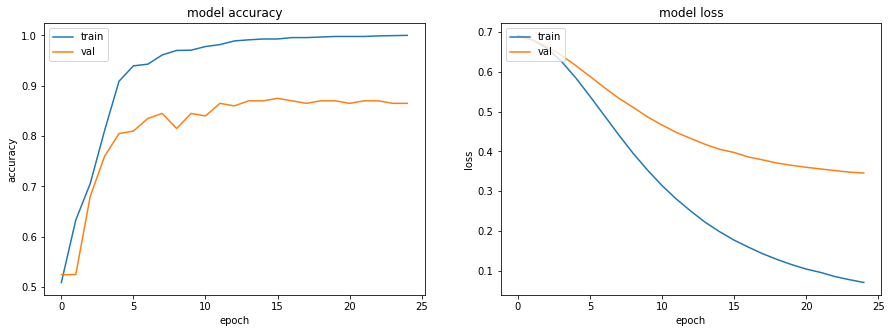

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

# Prediction Experiments

Try some reviews predictions

In [ ]:
def predict_sentiment(review):
    line=extract_words(review,dictionnary)
    encoded = tok.texts_to_matrix([line], mode='freq')
    pred = model.predict(encoded)
    percent_pos = pred[0, 0]
    if round(percent_pos) == 0:
        print('NEGATIVE: (%.3f%%)'%((1 - percent_pos)*100))
    else:
        print('POSITIVE: (%.3f%%)'%(percent_pos*100))


Easy classification

In [ ]:
predict_sentiment('I have never such a poor film, I want to be refunded ! Worst movie in the history !')
predict_sentiment('This movie is awesome, best movie ever !')
predict_sentiment('The quantity of characters in the movie makes the movie incoherent')

NEGATIVE: (98.403%)
POSITIVE: (98.576%)
NEGATIVE: (99.616%)


A simple word can change the prediction !

In [ ]:
predict_sentiment('An amazing and incredible scenario with a poor realisation')
predict_sentiment('An amazing scenario with a poor realisation')

POSITIVE: (76.389%)
NEGATIVE: (82.991%)


Prediction with neutral content about [western yellow robin](https://en.wikipedia.org/wiki/Western_yellow_robin) and with [spiral galaxies](https://en.wikipedia.org/wiki/Spiral_galaxy).

In [ ]:
predict_sentiment('The western yellow robin (Eopsaltria griseogularis) is a species of bird in the Australasian robin family Petroicidae.' 
'Described by John Gould in 1838, the western yellow robin and its Australian relatives are not closely related to either the European or American robins,'
' but appear to be an early offshoot of the Passerida group of songbirds.')

NEGATIVE: (98.945%)


In [ ]:
predict_sentiment('Spiral galaxies form a class of galaxy originally described by Edwin Hubble'
'in his 1936 work The Realm of the Nebulae[1] and, as such, form part of the Hubble sequence. ')

POSITIVE: (90.125%)


Prediction on an long anonymous review.

In [ ]:
predict_sentiment('In this movie “End Game” the avengers come together to defeat Thanos once and for all after losing.'
'After half of the universe was eliminated the avengers tried to find a solution but for that they need the help of ant-man.'
'He gaved them the clue to travel in time and so collect the different gems of infinity to restore the universe.'
'In mi opinion the movie gives us a final tribute to the entire saga and at the same time such an incredible moments like when Capitan America'
'raises the hammer of Thor and Hulk and Iron Man carry the gauntlet of infinity.'
'They also created the greatest crossover of the entire history and make the audience feel connected to the movie at that point that make us feel there.'
'The only thing i didn’t like of the movie is that they left behind some main characters and focus on others with not big importance '
'but apart from that it was the best movie i saw in my life. I really enojoyed it and i hope they continue to make more movies like this.')

POSITIVE: (78.298%)
